## Various Transition vs Bias scans
With balancing potential in channel (and 100mT field by accident)

Without field or balancing potential

With fields only


In [1]:
from JupyterImport import *
from src.Scripts.Aug17_TransitionVsBias import get_transition_vs_bias_repeats
root_logger.setLevel(logging.WARNING)

In [2]:
import plotly.io as pio
pio.templates.default = 'plotly_dark'
# plt.style.use(['dark_background'])

In [39]:
dat = get_dat(324)
# dat = get_dat(463)
x, y, z = dat.Data.x_array, dat.Data.y_array, dat.Data.i_sense
z = CU.decimate(z, dat.Logs.Fastdac.measure_freq, 100)
x = np.linspace(x[0], x[-1], z.shape[-1])

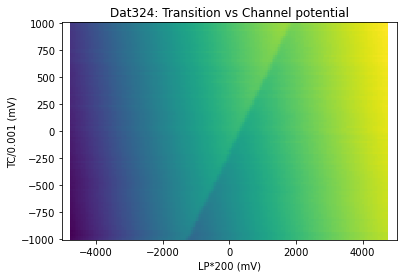

In [40]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
P.display_2d(x, y, z, ax, x_label=dat.Logs.x_label, y_label=dat.Logs.y_label)
ax.set_title(f'Dat{dat.datnum}: Transition vs Channel potential');

In [41]:
from src.DatObject.Attributes.Transition import i_sense_digamma_quad, i_sense
dat.Transition.avg_fit.params = None  # So that run row fits will estimate again
dat.Transition.run_row_fits(params=None, fit_func=i_sense_digamma_quad)
dat.Transition.run_avg_fit(fit_func=i_sense_digamma_quad)

thetas = [fit.best_values.theta for fit in dat.Transition.all_fits]
mids = [fit.best_values.mid for fit in dat.Transition.all_fits]

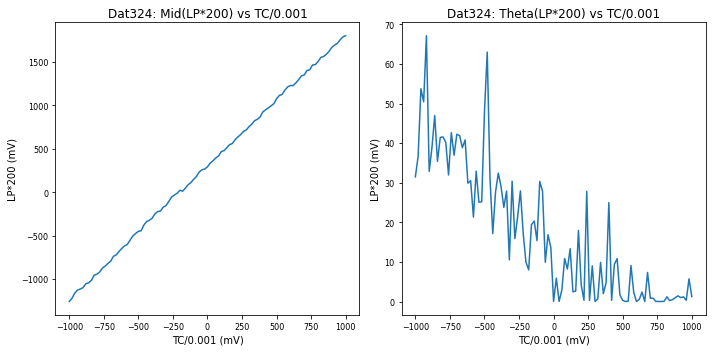

In [42]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
for ax, data, label in zip(axs, [mids, thetas], ['Mid', 'Theta']):
    ax.plot(y, data)
    P.ax_setup(ax, f'Dat{dat.datnum}: {label}(LP*200) vs TC/0.001', f'{dat.Logs.y_label}', f'{dat.Logs.x_label}')
plt.tight_layout()

Not sure how to interpret the thetas here... I am hoping for constant, or expecting to see an increase on either side of 0. I think this probably means fitting isn't working that well. Mid positions do make sense though, so for now I am going to use that to get an estimate of what my second square wave should be to keep the potential at the dot zero

In [43]:
line = lm.models.LinearModel()
fit = line.fit(np.array(mids).astype(np.float32), x=y[:].astype(np.float32))
print(fit.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 101
    # variables        = 2
    chi-square         = 27291.633
    reduced chi-square = 275.673059
    Akaike info crit   = 569.520708
    Bayesian info crit = 574.750949
[[Variables]]
    slope:      1.52648783 +/- 0.00283344 (0.19%) (init = 1)
    intercept:  298.641906 +/- 1.65216091 (0.55%) (init = 0)


Now to get an idea of what the offset is that I need to correct. Looking at fixed DCbias dats 307->321

In [8]:
dats = get_dats(range(307,321+1))
centers = [dat.Transition.avg_fit.best_values.mid  for dat in dats]
biases = [dat.Logs.fds['R2T(10M)'] for dat in dats]

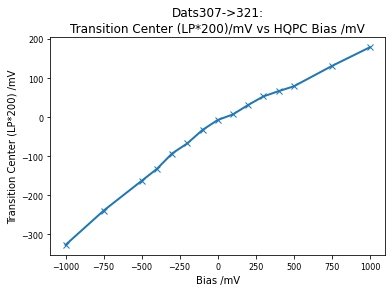

In [9]:
fig, ax = plt.subplots(1,1)
P.display_1d(biases, centers, ax, 'Bias /mV', 'Transition Center (LP*200) /mV', marker='x')
P.ax_setup(ax, f'Dats{dats[0].datnum}->{dats[-1].datnum}:\nTransition Center (LP*200)/mV vs HQPC Bias /mV')

In [10]:
line = lm.models.LinearModel()
fit = line.fit(centers, x=biases)
print(fit.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 15
    # variables        = 2
    chi-square         = 6789.52561
    reduced chi-square = 522.271201
    Akaike info crit   = 95.7262923
    Bayesian info crit = 97.1423927
[[Variables]]
    slope:      0.24901587 +/- 0.01112104 (4.47%) (init = 1)
    intercept: -34.0836536 +/- 5.90068477 (17.31%) (init = 0)


Using the above linear relationships, I have run another transition vs DC HQPC bias scan but this time with an offset voltage applied to the channel which hopefully results in zero potential at the dot. 

Dats 403 -> 409

In [11]:

dats = get_dats(range(403,409+1))

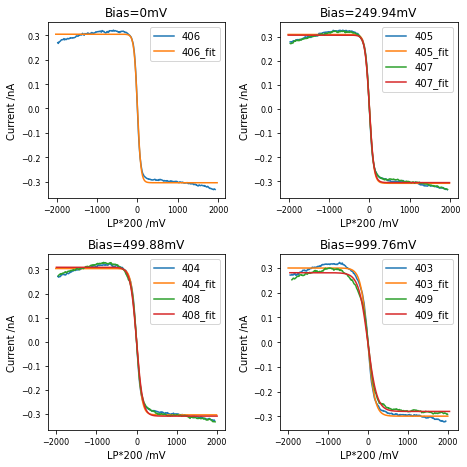

In [12]:
%matplotlib inline
tbr = get_transition_vs_bias_repeats(dats)
plt.tight_layout()

Above is with correction bias to make zero potential in channel.. Looks much better than below which is without.

### Without Field or Balancing Potential

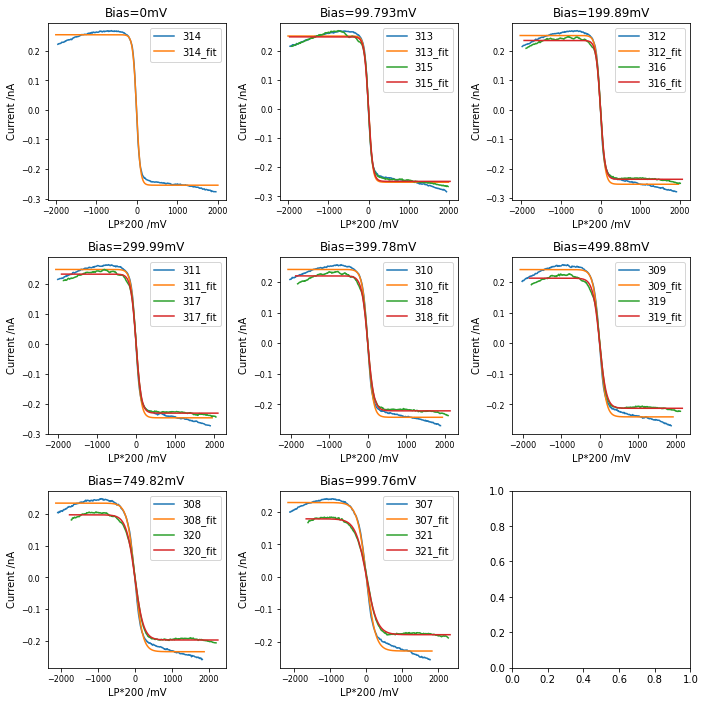

In [13]:
dats2 = get_dats(range(307,321+1))
tbr2 = get_transition_vs_bias_repeats(dats2)
plt.tight_layout()

### With Fields

In [14]:
dats = get_dats(range(337, 399+1))
fields = set([round(dat.Other.magy) for dat in dats])
dat_dict = {f: [dat for dat in dats if round(dat.Other.magy) == f] for f in fields}

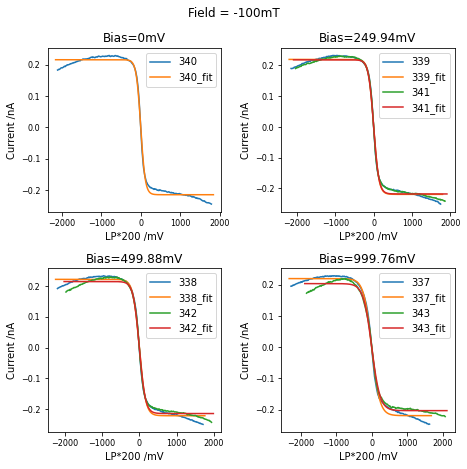

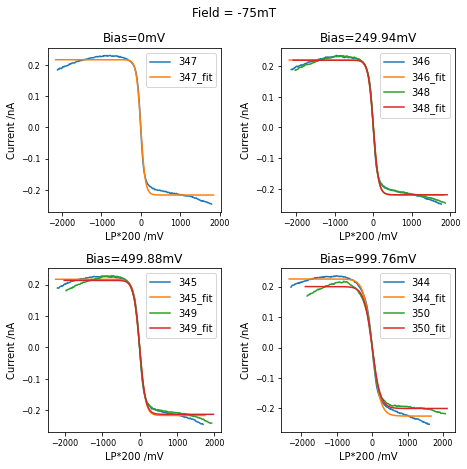

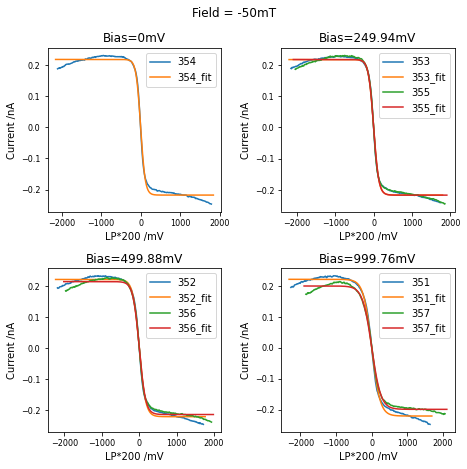

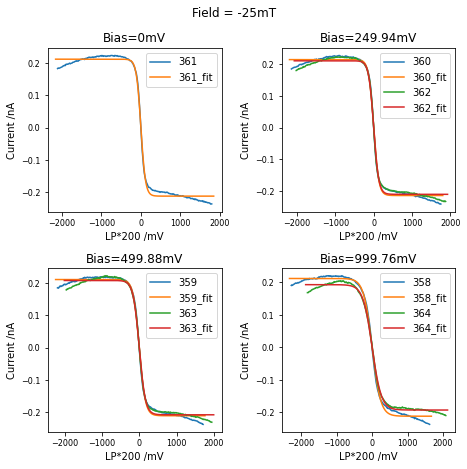

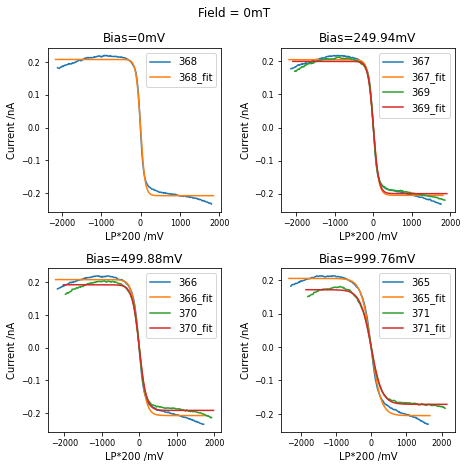

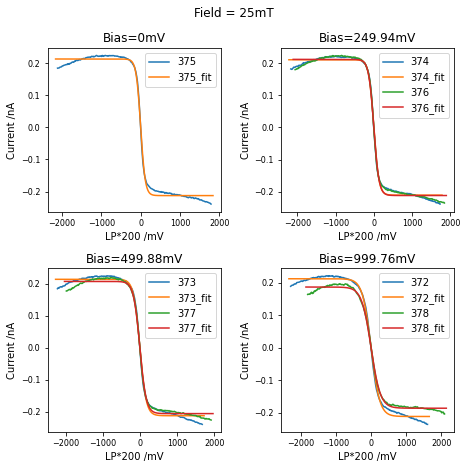

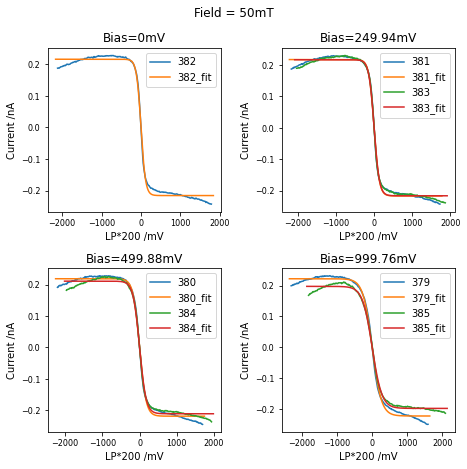

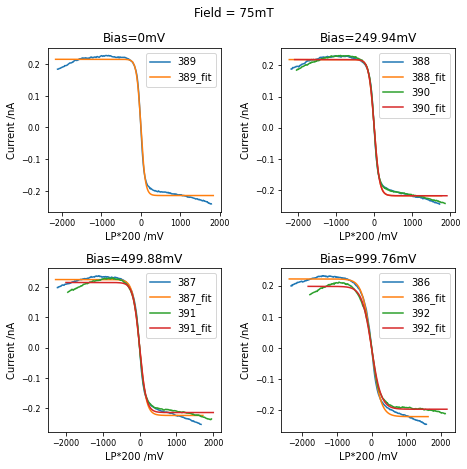

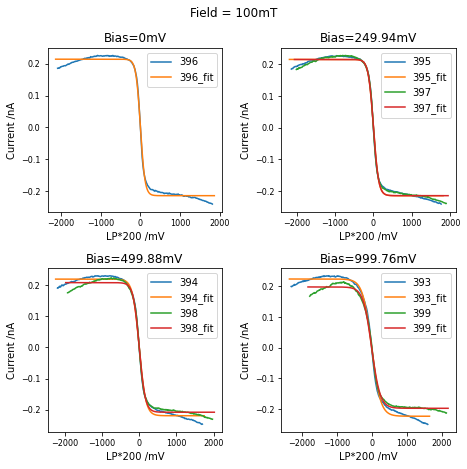

In [15]:
%matplotlib inline
tbrs = dict()
for k, v in sorted(dat_dict.items()):
    tbrs[k] = get_transition_vs_bias_repeats(v)
    tbrs[k].fig.suptitle(f'Field = {k}mT')
    tbrs[k].fig.figsize=(10,10)
    tbrs[k].fig.tight_layout()